### Load Processed Data

In [1]:
import numpy as np
import pickle

# Load the arrays
train_x = np.load('../processed_data/train_x.npy')
test_x = np.load('../processed_data/test_x.npy')
train_y_pos = np.load('../processed_data/train_y_pos.npy')
test_y_pos = np.load('../processed_data/test_y_pos.npy')
train_y_ner = np.load('../processed_data/train_y_ner.npy')
test_y_ner = np.load('../processed_data/test_y_ner.npy')


# Load the vocab dictionaries
with open('../processed_data/words_vocab.pkl', 'rb') as f:
    words_vocab = pickle.load(f)

with open('../processed_data/pos_vocab.pkl', 'rb') as f:
    pos_vocab = pickle.load(f)

with open('../processed_data/ners_vocab.pkl', 'rb') as f:
    ners_vocab = pickle.load(f)

# Load the words, poss, and ners lists
with open('../processed_data/words.pkl', 'rb') as f:
    words = pickle.load(f)

with open('../processed_data/poss.pkl', 'rb') as f:
    poss = pickle.load(f)

with open('../processed_data/ners.pkl', 'rb') as f:
    ners = pickle.load(f)

# Define the number of unique words, POS tags, and NER tags
nbr_words = len(words_vocab)
nbr_pos = len(pos_vocab)
nbr_ners = len(ners_vocab)

# Define maximum sentence length
max_len = 25


### Building the model

In [2]:
# import classes
import tensorflow as tf
import random
from keras.layers import Dense, Embedding, LSTM, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

In [3]:
# Set the seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
from keras import backend as K

# Clear previous session
K.clear_session()

In [5]:
print(f'vocab size = {len(words_vocab)}')
print(f'embedding size = {max_len}')
print(f'number of possible pos labels = {len(pos_vocab)}')
print(f'number of possible ner labels = {len(ners_vocab)}')

vocab size = 16248
embedding size = 25
number of possible pos labels = 15
number of possible ner labels = 21


### Model

In [6]:
# Define the model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=nbr_words, output_dim=25, input_length=max_len)(input_layer)
lstm_layer = LSTM(units=100, activation='tanh', return_sequences=True, recurrent_dropout=0.1)(embedding_layer)

In [7]:
# Output layers for POS and NER
pos_output = Dense(nbr_pos, activation='softmax', name='pos_output')(lstm_layer)
ner_output = Dense(nbr_ners, activation='softmax', name='ner_output')(lstm_layer)

In [8]:
# Define the model with two outputs
model = Model(inputs=input_layer, outputs=[pos_output, ner_output])

# Compile the model
model.compile(optimizer="adam",
              loss={"pos_output": "sparse_categorical_crossentropy", "ner_output": "sparse_categorical_crossentropy"},
              metrics=["accuracy"])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 25)       406200      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 25, 100)      50400       ['embedding[0][0]']              
                                                                                                  
 pos_output (Dense)             (None, 25, 15)       1515        ['lstm[0][0]']                   
                                                                                                  
 ner_output (Dense)             (None, 25, 21)       2121        ['lstm[0][0]']                   
                                                                                                  
Total para

In [9]:
print(f"Unique POS labels: {np.unique(np.concatenate(train_y_pos))}")
print(f"Unique NER labels: {np.unique(np.concatenate(train_y_ner))}")

print(f"Number of POS classes: {nbr_pos}")
print(f"Number of NER classes: {nbr_ners}")

Unique POS labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Unique NER labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Number of POS classes: 15
Number of NER classes: 21


In [10]:
# # Example of ensuring labels are correctly encoded
# def encode_labels(labels, vocab_size):
#     """Ensure all label values are within the range [0, vocab_size-1]."""
#     encoded_labels = np.clip(labels, 0, vocab_size - 1)
#     return encoded_labels

# # Apply this function to your labels
# train_y_pos = encode_labels(train_y_pos, nbr_pos)
# train_y_ner = encode_labels(train_y_ner, nbr_ners)
# test_y_pos = encode_labels(test_y_pos, nbr_pos)
# test_y_ner = encode_labels(test_y_ner, nbr_ners)

### Test-Validation Split

In [11]:
from sklearn.model_selection import train_test_split
val_x, test_x, val_y_pos, test_y_pos, val_y_ner, test_y_ner = train_test_split(
    test_x, test_y_pos, test_y_ner, test_size=0.5, random_state=seed
)

In [14]:
ners_vocab

{'B-D&T': 17,
 'B-EVENT': 5,
 'B-GPE': 10,
 'B-LOC': 4,
 'B-MISC': 18,
 'B-NUM': 2,
 'B-ORG': 6,
 'B-OTH': 13,
 'B-PER': 12,
 'B-T&T': 20,
 'B-UNIT': 1,
 'I-D&T': 15,
 'I-EVENT': 7,
 'I-GPE': 19,
 'I-LOC': 3,
 'I-MISC': 11,
 'I-NUM': 8,
 'I-ORG': 9,
 'I-PER': 0,
 'I-T&T': 14,
 'I-UNIT': 16}

In [15]:
# Print shapes to verify splits
print(f"Train X shape: {np.array(train_x).shape}")
print(f"Validation X shape: {np.array(val_x).shape}")
print(f"Test X shape: {np.array(test_x).shape}")
print(f"Train Y POS shape: {np.array(train_y_pos).shape}")
print(f"Validation Y POS shape: {np.array(val_y_pos).shape}")
print(f"Test Y POS shape: {np.array(test_y_pos).shape}")
print(f"Train Y NER shape: {np.array(train_y_ner).shape}")
print(f"Validation Y NER shape: {np.array(val_y_ner).shape}")
print(f"Test Y NER shape: {np.array(test_y_ner).shape}")

Train X shape: (3246, 25)
Validation X shape: (406, 25)
Test X shape: (406, 25)
Train Y POS shape: (3246, 25)
Validation Y POS shape: (406, 25)
Test Y POS shape: (406, 25)
Train Y NER shape: (3246, 25)
Validation Y NER shape: (406, 25)
Test Y NER shape: (406, 25)


In [16]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_pos_output_accuracy', min_delta=0, patience=10, verbose=1, mode='max')

# Train the model
history = model.fit(train_x, {"pos_output": train_y_pos, "ner_output": train_y_ner},
                    validation_data=(val_x, {"pos_output": val_y_pos, "ner_output": val_y_ner}),
                    batch_size=32,
                    epochs=100,
                    callbacks=[early_stopping])

Epoch 1/100
102/102 [==============================] - 7s 40ms/step - loss: 2.9752 - pos_output_loss: 1.4817 - ner_output_loss: 1.4935 - pos_output_accuracy: 0.5807 - ner_output_accuracy: 0.6442 - val_loss: 2.1900 - val_pos_output_loss: 1.1713 - val_ner_output_loss: 1.0186 - val_pos_output_accuracy: 0.6764 - val_ner_output_accuracy: 0.8055
Epoch 2/100
102/102 [==============================] - 3s 34ms/step - loss: 1.8875 - pos_output_loss: 1.0272 - ner_output_loss: 0.8603 - pos_output_accuracy: 0.7145 - ner_output_accuracy: 0.8369 - val_loss: 1.7741 - val_pos_output_loss: 0.9878 - val_ner_output_loss: 0.7863 - val_pos_output_accuracy: 0.7198 - val_ner_output_accuracy: 0.8460
Epoch 3/100
102/102 [==============================] - 2s 24ms/step - loss: 1.6409 - pos_output_loss: 0.9196 - ner_output_loss: 0.7213 - pos_output_accuracy: 0.7285 - ner_output_accuracy: 0.8577 - val_loss: 1.6444 - val_pos_output_loss: 0.9345 - val_ner_output_loss: 0.7099 - val_pos_output_accuracy: 0.7247 - val_ne

In [17]:
history.history.keys()

dict_keys(['loss', 'pos_output_loss', 'ner_output_loss', 'pos_output_accuracy', 'ner_output_accuracy', 'val_loss', 'val_pos_output_loss', 'val_ner_output_loss', 'val_pos_output_accuracy', 'val_ner_output_accuracy'])

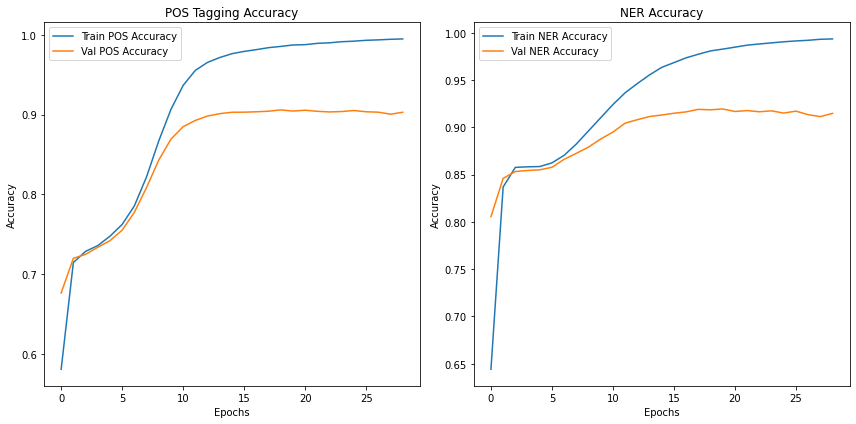

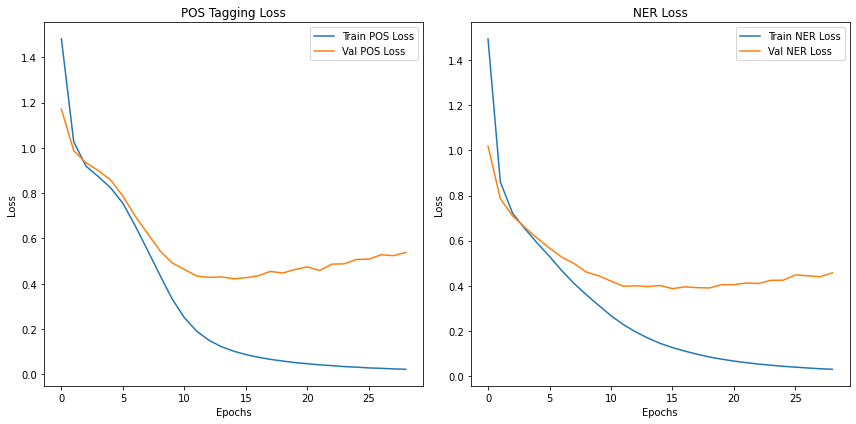

In [18]:
import matplotlib.pyplot as plt

# Extract training and validation metrics from the history object
history_dict = history.history

# Plot accuracy
plt.figure(figsize=(12, 6))

# Plot POS Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['pos_output_accuracy'], label='Train POS Accuracy')
plt.plot(history_dict['val_pos_output_accuracy'], label='Val POS Accuracy')
plt.title('POS Tagging Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot NER Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['ner_output_accuracy'], label='Train NER Accuracy')
plt.plot(history_dict['val_ner_output_accuracy'], label='Val NER Accuracy')
plt.title('NER Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))

# Plot POS Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['pos_output_loss'], label='Train POS Loss')
plt.plot(history_dict['val_pos_output_loss'], label='Val POS Loss')
plt.title('POS Tagging Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot NER Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['ner_output_loss'], label='Train NER Loss')
plt.plot(history_dict['val_ner_output_loss'], label='Val NER Loss')
plt.title('NER Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Evaluate the model

In [19]:
# Evaluate the model on the test data
test_loss, test_pos_loss, test_ner_loss, test_pos_accuracy, test_ner_accuracy = model.evaluate(test_x, {"pos_output": test_y_pos, "ner_output": test_y_ner}, batch_size=128)
print(f"Test Loss: {test_loss}")
print(f"Test POS Loss: {test_pos_loss}")
print(f"Test NER Loss: {test_ner_loss}")
print(f"Test POS Accuracy: {test_pos_accuracy}")
print(f"Test NER Accuracy: {test_ner_accuracy}")

4/4 [==============================] - 0s 12ms/step - loss: 0.9656 - pos_output_loss: 0.4983 - ner_output_loss: 0.4672 - pos_output_accuracy: 0.9079 - ner_output_accuracy: 0.9141
Test Loss: 0.9655945897102356
Test POS Loss: 0.4983460009098053
Test NER Loss: 0.4672486186027527
Test POS Accuracy: 0.9078817963600159
Test NER Accuracy: 0.9140886664390564


In [39]:
from sklearn.metrics import classification_report, accuracy_score
# Make predictions on the test set
predictions = model.predict(test_x)

# Extract predictions for POS and NER based on their positions
pred_pos = np.argmax(predictions[0], axis=-1)
pred_ner = np.argmax(predictions[1], axis=-1)

# Convert test_y to the appropriate format
true_pos = np.array(test_y_pos)
true_ner = np.array(test_y_ner)

# Flatten the arrays for metric calculation
pred_pos_flat = pred_pos.flatten()
true_pos_flat = true_pos.flatten()
pred_ner_flat = pred_ner.flatten()
true_ner_flat = true_ner.flatten()

# Remove padding values from the flattened arrays for metrics calculation
valid_pos_indices = true_pos_flat != nbr_pos-1
valid_ner_indices = true_ner_flat != nbr_ners-1

# Filter out the padding values
true_pos_filtered = true_pos_flat[valid_pos_indices]
pred_pos_filtered = pred_pos_flat[valid_pos_indices]
true_ner_filtered = true_ner_flat[valid_ner_indices]
pred_ner_filtered = pred_ner_flat[valid_ner_indices]

13/13 [==============================] - 0s 7ms/step


In [46]:
# Calculate metrics for POS
# Calculate metrics for POS
pos_accuracy = accuracy_score(true_pos_filtered, pred_pos_filtered)
pos_classification_report = classification_report(true_pos_filtered, pred_pos_filtered, target_names=list(pos_vocab.keys()), zero_division=0)
print("POS Tagging Metrics:")
print(f"Accuracy: {pos_accuracy}")
print(f"\nClassification Report:\n {pos_classification_report}")

POS Tagging Metrics:
Accuracy: 0.798593785438875

Classification Report:
               precision    recall  f1-score   support

        CONJ       0.94      0.93      0.93        97
         VNF       0.91      0.78      0.84       147
         ADV       0.86      0.66      0.75       145
          VF       0.97      0.81      0.89       419
          QF       0.97      0.83      0.89       177
        INTJ       0.00      0.00      0.00         4
         OTH       1.00      0.56      0.71         9
         NNC       0.74      0.92      0.82      1770
        PART       1.00      0.40      0.57         5
         NNP       0.75      0.57      0.65       772
          PP       0.90      0.89      0.90       171
         ADJ       0.80      0.65      0.72       489
         DET       0.90      0.93      0.91        81
         PRO       0.96      0.89      0.92       123
       PUNCT       0.00      0.00      0.00         0

    accuracy                           0.80      4409
   mac

In [54]:
# Calculate metrics for NER
ner_accuracy = accuracy_score(true_ner_filtered, pred_ner_filtered)
ner_classification_report = classification_report(true_ner_filtered, pred_ner_filtered, zero_division=0)

print("NER Tagging Metrics:")
print(f"Accuracy: {ner_accuracy}")
print(f"\nClassification Report:\n {ner_classification_report}")

NER Tagging Metrics:
Accuracy: 0.8085248828386521

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.49      0.59       162
           1       0.66      0.83      0.73        23
           2       0.92      0.79      0.85       126
           3       0.10      0.08      0.09        24
           4       0.25      0.13      0.17        53
           5       0.59      0.46      0.52        65
           6       0.57      0.45      0.51       159
           7       0.11      0.38      0.18        26
           8       1.00      0.87      0.93        23
           9       0.43      0.38      0.40       104
          10       0.86      0.51      0.64        94
          11       0.00      0.00      0.00         0
          12       0.71      0.51      0.59       382
          13       0.87      0.94      0.90      3050
          14       0.00      0.00      0.00         8
          15       0.71      0.95      0.81        60
      

In [48]:
# Save metrics to a text file
with open('../reports/score_1_base.txt', 'w') as file:
    # Write POS metrics
    file.write("POS Tagging Metrics:\n")
    file.write(f"Accuracy: {pos_accuracy}\n\n")
    file.write("Classification Report:\n")
    file.write(pos_classification_report)
    
    # Write NER metrics
    file.write("\nNER Tagging Metrics:\n")
    file.write(f"Accuracy: {ner_accuracy}\n\n")
    file.write("Classification Report:\n")
    file.write(ner_classification_report)

print("Metrics have been saved to '../reports/metrics.txt'.")

Metrics have been saved to '../reports/metrics.txt'.
